In [109]:
import numpy as np
from math import *
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt

In [51]:
#Initialize state, action, policy, value spaces
max_cars = 20

states = [[i,j] for i in range(max_cars+1) for j in range(max_cars+1)]
actions = np.arange(-5,5+1)
values = np.zeros((max_cars+1,max_cars+1))
policy = values.copy()

In [18]:
#Poisson probability
poisson_prob = lambda n,lam:((lam**n)/factorial(n))*np.exp(-lam)

In [57]:
#value function
def expected_value(state,action):
    val = 0

    #constants
    fee = 2
    profit = 10
    discount = 0.9

    val -= fee*np.abs(action)

    #initial cars at locations
    cars1 = max(min(state[0] - action, max_cars),0)
    cars2 = max(min(state[1] + action, max_cars),0)

    #rentals and returns
    for rentals1 in range(11):
        for rentals2 in range(11):
            rental_prob = poisson_prob(rentals1,3)*poisson_prob(rentals2,4)

            real_rentals1 = min(rentals1, cars1)
            real_rentals2 = min(rentals2, cars2)

            reward = profit*(real_rentals1 + real_rentals2)

            for returns1 in range(11):
                for returns2 in range(11):
                    total_prob = poisson_prob(returns1,3)*poisson_prob(returns2,2)*rental_prob

                    #cars at end of day
                    new_cars1 = max(min(cars1 - real_rentals1 + returns1,max_cars),0)
                    new_cars2 = max(min(cars2 - real_rentals2 + returns2,max_cars),0)

                    val += total_prob*(reward + discount * values[int(new_cars1),int(new_cars2)])
    return val

In [ ]:
#POLICY ITERATION
threshold = 1e-4

#policy evaluation
def policy_evaluation():
    while(True):
        delta = 0
        for i,j in states:
            old_val = values[i,j]
            values[i,j] = expected_value([i,j],policy[i,j])
            delta = max(delta, np.abs(old_val-values[i,j]))
    
            print('.', end = '')
            sys.stdout.flush()
    
        print(delta)
        sys.stdout.flush()
        
        if delta<threshold:
            break

#policy improvement
def policy_improvement():
    policy_stable = True
    for i,j in states:
        old_action = policy[i,j]

        max_action = None
        max_action_val = None

        max_possible_action1 = min(i,5)
        max_possible_action2 = -min(j,5)

        for action in range(max_possible_action2,max_possible_action1+1):
            if max_action_val == None:
                max_action_val = expected_value([i,j],action)
                max_action = action

            elif max_action_val < expected_value([i,j],action):
                max_action_val = expected_value([i,j],action)
                max_action = action

        policy[i,j] = max_action

        if old_action != policy[i,j]:
            policy_stable = False
            
            
    return policy_stable

while(True):
    policy_evaluation()
    stable = policy_improvement()
    if stable:
        break

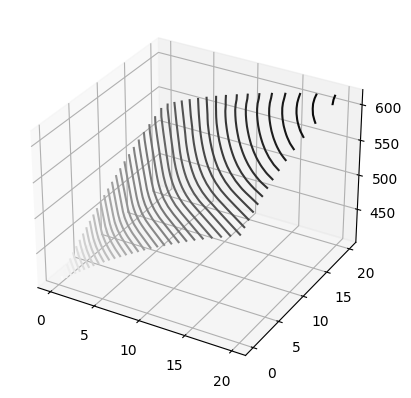

In [108]:
%matplotlib inline
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.contour3D(range(21), range(21), values, 50, cmap='binary')


In [145]:
def save_values(values,filename):
    PATH = 'jcp/found_value_spaces'
    if not os.path.exists(PATH):
        os.makedirs(PATH)

    pd.DataFrame(values).to_csv(os.path.join(PATH,f'{filename}.csv'))

def save_policy(policy,filename):
    PATH = 'jcp/found_policy_spaces'
    if not os.path.exists(PATH):
        os.makedirs(PATH)

    pd.DataFrame(policy).to_csv(os.path.join(PATH,f'{filename}.csv'))

In [146]:
save_values(values,'first_values')
save_policy(policy,'first_policy')